# Assignment 1

## 4. Exact Diagonalization study of the quantum Ising model

### 4.1 Dense ED

Generate the quantum Ising Hamiltonian (4) as a dense matrix and call an explicit diagonalization routine for the entire spectrum for system sizes $L = 8, 10, 12, 14,$ and for a range of values of h. Plot the ground state energy as a function of $h$ for the various $L$. Compare the open systems with periodic ones for the same parameters—how does each phase react to the boundaries?


import relevant packages

In [92]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm
import time
directory = 'figures'
import os
if not os.path.exists(directory):
    os.makedirs(directory)
from multiprocessing import Pool
from functools import partial

### Implementation of the dense Hamiltonian

The Hamiltonian of the quantum Ising chain is given by

$$H = -J \sum_{j=1}^{L-1} \sigma_z^j \sigma_z^{j+1} - h \sum_{j=1}^{L} \sigma_x^j $$

Instead of having to do all these time-consuming Kronecker products we can quickly realize that 

$$		H_{\alpha \beta} = \langle e_\alpha | H | e_\beta \rangle \neq 0 \quad \text{if} \quad 
		\begin{cases}
			\alpha = \beta \\
			\text{or } \alpha \text{ and } \beta \text{ differ by a single bit flip.}
		\end{cases}$$
        
This is because $|\uparrow \rangle$ and $|\downarrow \rangle$ are eigenstates of $\sigma_z$ and $\sigma_x$ flips $|\uparrow \rangle \longleftrightarrow |\downarrow \rangle$. The states $| e_\alpha \rangle$  are defined in an orthogonal basis as follows:


\begin{align*}
|e_0\rangle &= |000 \ldots 0\rangle, \\
|e_1\rangle &= |100 \ldots 0\rangle, \\
|e_2\rangle &= |010 \ldots 0\rangle, \\
|e_3\rangle &= |110 \ldots 0\rangle, \\
&\text{and so on.}
\end{align*}


Where $0$ represents $|\uparrow \rangle$ and $1$ represents $|\downarrow \rangle$. Now that we have the states represented as integers, we can use fast bit operations to quickly construct the Hamiltonian.

In [103]:
def denseH(L, J, h, periodic):
    """
    generates the dense Hamiltonian matrix for the quantum Ising chain
    
        Parameters:
            L (int): length of chain
            J (float): ising interaction strength
            h (float): magnetic field strength
            periodic (bool): does the chain have periodic boundary conditions?
            
        Returns:
            H (ndarray): 2^L x 2^L matrix representing the Hamiltonian operator
    """

    dim=2**L # dimensions of the Hilbert space
    
    H=np.zeros((dim, dim)) # initliaze the Hamiltonian
    
    "Calculation of off-diagonal elements due to the magnetic field"
    
    for beta in range(dim): # iterate over all states
        
        for j in range(1,L+1): # iterate over all sites
            
            alpha = beta ^ (1<<j-1) # flips jth bit of beta to get the state alpha that is related to beta by a single bit flip
            
            H[alpha, beta] -= h # contribution by sigma^j_x
            
    "Calculation of diagonal elements due to Ising interaction"

    for alpha in range(dim): # iterate over all states
        
        for j in range(1, L): # iterate over all sites
            
            if 2*(alpha & (1 << j-1)) == alpha & (1 << j): # check if site j and j+1 have the same spin
                
                H[alpha, alpha] -= J # if they do, decrease the energy by the ising interaction term
                
            else:
                
                H[alpha, alpha] += J # if not, increase the energy by the ising interaction term
        
        "Handling case of periodic boundary conditions"
                
        if periodic and L > 1: # L > 1 needed for periodicity to mean anything
            
            if (alpha & (1 << L-1)) == ((alpha & (1 << 0))*(2**(L-1))): # Check if the states at either end have the same spin
                
                H[alpha, alpha] -= J # if they do, decrease the energy by the ising interaction term
                
            else:
                
                H[alpha, alpha] += J # if not, increase the energy by the ising interaction term
                
    return H
    

### Dense diagonalization implementation

In [109]:
def denseEgs(L, J, h, periodic):
    """
    returns the ground state eigenenergy of the Ising chain
    
        Parameters:
            L (int): length of chain
            J (float): ising interaction strength
            h (float): magnetic field strength
            periodic (bool): does the chain have periodic boundary conditions?
        
        Returns:
            ground_state (float): ground state energy
    """

    H = denseH(L, J, h , periodic) # construct the dense Hamiltonian
    
    ground_state = scipy.linalg.eigh(H, subset_by_index=(0, 0), eigvals_only=True)[0] # return only the smallest eigenvalue (increases the speed quite a bit)
    
    return ground_state 

### Plotting the ground state energy as a function of h for various L

Calculating for L=10: 100%|████████████████████████████████████████████████████████████| 20/20 [00:52<00:00,  2.65s/it]


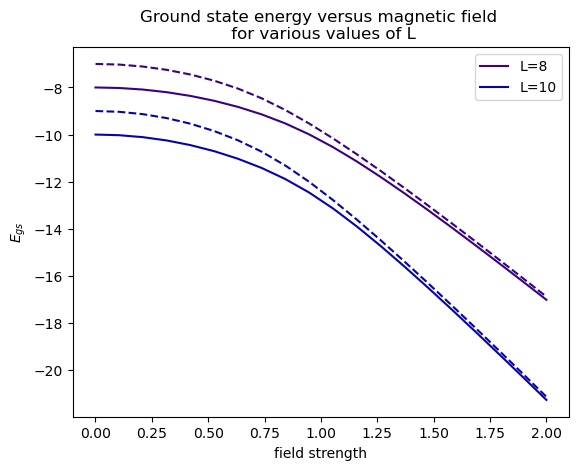

In [110]:
# initialize
L_values = [8, 10, 12, 14] 
h_values = np.linspace(0, 2, 20) # the problem is symmetric about h = 0, so we can cut computation-time in half by computing only positive h
periodicgs = {L: [] for L in L_values}
opengs = {L: [] for L in L_values}

"Plot Egs vs h for both periodic and open boundary conditions"

for L in L_values:
    for h in tqdm(h_values, desc=f'Calculating for L={L}'):
        periodicgs[L].append(denseEgs(L, 1, h, True))
        opengs[L].append(denseEgs(L, 1, h, False))
        
# Dashed line -> Open
# Solid line -> Periodic
        
for i, (L, energies) in enumerate(periodicgs.items()):
    plt.plot(h_values, energies, label=f'L={L}', color=xkcd_colors[i])
    
for i, (L, energies) in enumerate(opengs.items()):
    plt.plot(h_values, energies, color=xkcd_colors[i], linestyle='--')

plt.xlabel('field strength')
plt.ylabel(r'$E_{gs}$')
plt.title('Ground state energy versus magnetic field \n for various values of L')
plt.legend()
plt.savefig(os.path.join(directory, 'openvsperiodicEgs.png'), dpi=400)
plt.show()




In [3]:
def sparseH(L, J, h, periodic):
    dim = 2 ** L
    H_data = []
    H_rows = []
    H_cols = []

    for beta in range(dim):
        for j in range(1, L + 1):
            alpha = beta ^ (1 << (j - 1))
    
            H_data.append(-h)
            H_rows.append(alpha)
            H_cols.append(beta)

    for alpha in range(dim):
        A = 0
        for j in range(1, L):
            if 2 * (alpha & (1 << (j - 1))) == alpha & (1 << j):
                A -= J
            else:
                A += J
                
        if periodic:
            if (alpha & (1 << (L - 1))) == ((alpha & (1 << 0)) * (2 ** (L - 1))):
                A -= J
            else:
                A += J
        
        if A != 0:
            H_data.append(A)
            H_rows.append(alpha)
            H_cols.append(alpha)

    H_data = np.array(H_data, dtype=float)

    return scipy.sparse.csr_matrix((H_data, (H_rows, H_cols)), shape=(dim, dim), dtype=np.float64)

In [84]:
def H_operator(L, J, h, periodic, psi):
    dim = 2 ** L

    Hpsi = np.zeros(dim, dtype=np.float64)

    for beta in range(dim):
            for j in range(1, L + 1):
                alpha = beta ^ (1 << (j - 1))
                Hpsi[alpha] -= h * psi[beta]
        
        for alpha in range(dim):
            A = 0
            for j in range(1, L):
                if 2 * (alpha & (1 << (j - 1))) == alpha & (1 << j):
                    A -= J
                else:
                    A += J
                    
            if periodic and L > 1:  
                if (alpha & (1 << (L - 1))) == ((alpha & (1 << 0)) * (2 ** (L - 1))):
                    A -= J
                else:
                    A += J
            
            Hpsi[alpha] += A * psi[alpha]
        
        return Hpsi
    
    return scipy.sparse.linalg.LinearOperator((dim, dim), matvec=H_psi)

In [23]:
L_values = [8,10,12,14]
ground_state_energies = {L: [] for L in L_values}

def calculate_h_values(L):
    
    if L==8:
        return 50
    if L==10:
        return 25
    if L==12:
        return 20
    if L==14:
        return 15
    else:
        return 20


for L in L_values:
    h_values = np.linspace(0, 2, calculate_h_values(L))
    for h in tqdm(h_values, desc=f'Calculating for L={L}'):
        H = denseH(L, 1, h, True)
        ground_state = scipy.linalg.eigh(H, subset_by_index=(0, 0), eigvals_only=True)
        ground_state_energies[L].append(ground_state)

Calculating for L=14: 100%|███████████████████████████████████████████████████████████| 15/15 [28:12<00:00, 112.84s/it]


Calculating for L=14: 100%|████████████████████████████████████████████████████████████| 15/15 [00:16<00:00,  1.10s/it]


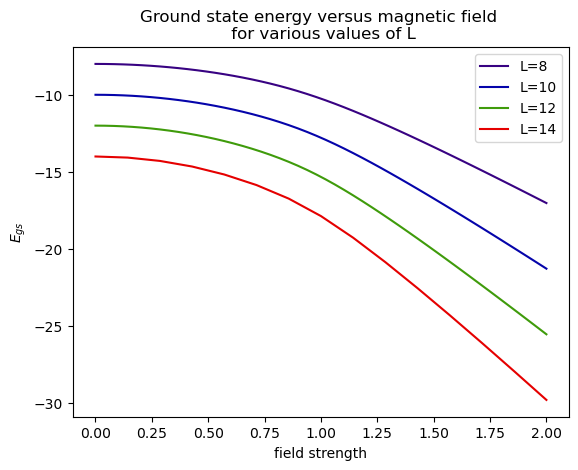

In [100]:
L_values = [8,10,12,14]
ground_state_energies = {L: [] for L in L_values}

def calculate_h_values(L):
    
    if L==14:
        return 15
    
    else:
        return 50


for L in L_values:
    h_values = np.linspace(0, 2, calculate_h_values(L))
    for h in tqdm(h_values, desc=f'Calculating for L={L}'):
        H = sparseH(L, 1, h, True)
        ground_state = scipy.sparse.linalg.eigsh(H, k=1, which='SA')[0]
        ground_state_energies[L].append(ground_state)

for i, (L, energies) in enumerate(ground_state_energies.items()):
    h_values = np.linspace(0, 2, calculate_h_values(L))
    plt.plot(h_values, energies, label=f'L={L}', color=xkcd_colors[i])

plt.xlabel('field strength')
plt.ylabel(r'$E_{gs}$')
plt.title('Ground state energy versus magnetic field \n for various values of L')
plt.legend()
plt.savefig(os.path.join(directory, 'plot-dense.png'), dpi=400)
plt.show()


In [105]:
L_values = [8,10,12]
h_values = np.linspace(0, 2, 20)
periodicgs = {L: [] for L in L_values}
opengs = {L: [] for L in L_values}


for L in L_values:
    for h in tqdm(h_values, desc=f'Calculating for L={L}'):
        Hper = sparseH(L, 1, h, True)
        Hopen = sparseH(L, 1, h, False)
        ground_state = scipy.sparse.linalg.eigsh(Hper, k=1, which='SA')[0]
        periodicgs[L].append(ground_state)
        ground_state = scipy.sparse.linalg.eigsh(Hopen, k=1, which='SA')[0]
        opengs[L].append(ground_state)


Calculating for L=12: 100%|████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.89it/s]


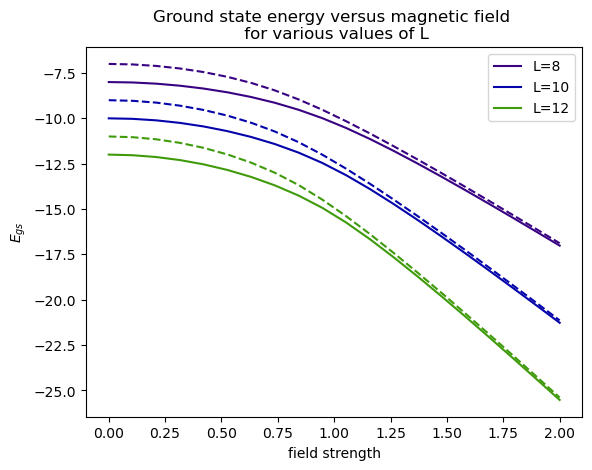

In [106]:
for i, (L, energies) in enumerate(periodicgs.items()):
    plt.plot(h_values, energies, label=f'L={L}', color=xkcd_colors[i])
    
for i, (L, energies) in enumerate(opengs.items()):
    plt.plot(h_values, energies, color=xkcd_colors[i], linestyle='--')

plt.xlabel('field strength')
plt.ylabel(r'$E_{gs}$')
plt.title('Ground state energy versus magnetic field \n for various values of L')
plt.legend()
# plt.savefig(os.path.join(directory, 'openvsperiodic1.png'), dpi=400)
plt.show()


In [40]:
def Egs(L, J, h , periodic):
    H = sparseH(L, J, h, periodic)
    return scipy.sparse.linalg.eigsh(H, k=1, which='SA', return_eigenvectors=False)[0]

In [58]:
paraPERIODIC=[]
ferroPERIODIC=[]
paraOPEN=[]
ferroOPEN=[]
Ls = list(range(2, 25))  

for L in tqdm(Ls, desc="Calculating energies"):
    start_time = time.time()
    ferroPERIODIC.append(Egs(L, 1, 0.3, True)/L)
    paraPERIODIC.append(Egs(L, 1, 1.7, True)/L)
    ferroOPEN.append(Egs(L, 1, 0.3, False)/L)
    paraOPEN.append(Egs(L, 1, 1.7, False)/L)
    elapsed_time = time.time() - start_time
    print(f"L = {L}, Time taken: {elapsed_time:.2f} seconds")
    

Calculating energies:  30%|██████████████████▌                                          | 7/23 [00:00<00:00, 59.94it/s]

L = 2, Time taken: 0.00 seconds
L = 3, Time taken: 0.00 seconds
L = 4, Time taken: 0.01 seconds
L = 5, Time taken: 0.01 seconds
L = 6, Time taken: 0.02 seconds
L = 7, Time taken: 0.03 seconds
L = 8, Time taken: 0.04 seconds
L = 9, Time taken: 0.08 seconds
L = 10, Time taken: 0.22 seconds
L = 11, Time taken: 0.47 seconds
L = 12, Time taken: 1.08 seconds
L = 13, Time taken: 2.10 seconds


Calculating energies:  57%|█████████████████████████████████▉                          | 13/23 [00:08<00:08,  1.22it/s]

L = 14, Time taken: 4.93 seconds
L = 15, Time taken: 9.97 seconds


Calculating energies:  65%|███████████████████████████████████████▏                    | 15/23 [00:37<00:28,  3.59s/it]

L = 16, Time taken: 18.36 seconds


Calculating energies:  70%|█████████████████████████████████████████▋                  | 16/23 [01:15<00:56,  8.05s/it]

L = 17, Time taken: 38.09 seconds


Calculating energies:  74%|████████████████████████████████████████████▎               | 17/23 [02:32<01:52, 18.75s/it]

L = 18, Time taken: 76.69 seconds


Calculating energies:  78%|██████████████████████████████████████████████▉             | 18/23 [05:03<03:34, 42.87s/it]

L = 19, Time taken: 151.28 seconds


Calculating energies:  83%|█████████████████████████████████████████████████▌          | 19/23 [10:01<06:22, 95.56s/it]

L = 20, Time taken: 298.13 seconds


Calculating energies:  87%|███████████████████████████████████████████████████▎       | 20/23 [19:53<10:25, 208.48s/it]

L = 21, Time taken: 591.48 seconds


Calculating energies:  91%|█████████████████████████████████████████████████████▊     | 21/23 [39:56<15:05, 452.75s/it]

L = 22, Time taken: 1203.64 seconds


Calculating energies:  96%|█████████████████████████████████████████████████████▌  | 22/23 [1:23:54<17:00, 1020.11s/it]

L = 23, Time taken: 2638.14 seconds


Calculating energies: 100%|█████████████████████████████████████████████████████████| 23/23 [4:39:48<00:00, 729.95s/it]

L = 24, Time taken: 11753.91 seconds


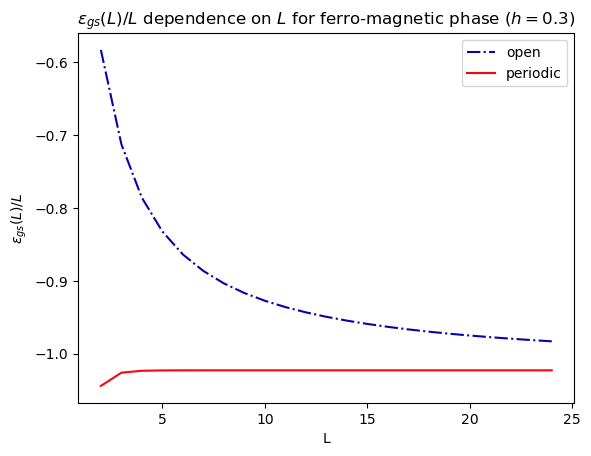

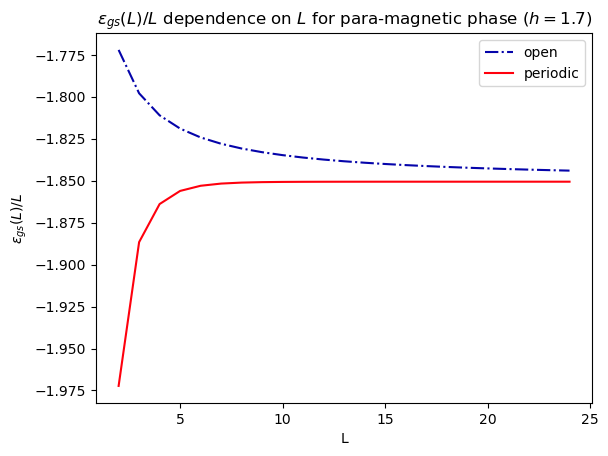

In [79]:
plt.plot(Ls, ferroOPEN, label='open', linestyle="dashdot", color='xkcd:royal blue')
plt.plot(Ls, ferroPERIODIC, label="periodic", color="xkcd:bright red")
plt.legend()
plt.xlabel('L')
plt.ylabel(r'$\epsilon_{gs}(L)/L$')
plt.title( r'$\epsilon_{gs}(L)/L$ dependence on $L$ for ferro-magnetic phase ($h=0.3$)')
plt.savefig(os.path.join(directory, 'ferro_open_periodic.png'), dpi=400)
plt.show()



plt.plot(Ls, paraOPEN, label='open', linestyle="dashdot", color='xkcd:royal blue')
plt.plot(Ls, paraPERIODIC, label="periodic", color="xkcd:bright red")
plt.title( r'$\epsilon_{gs}(L)/L$ dependence on $L$ for para-magnetic phase ($h=1.7$)')
plt.xlabel('L')
plt.ylabel(r'$\epsilon_{gs}(L)/L$')
plt.legend()
plt.savefig(os.path.join(directory, 'para_open_periodic.png'), dpi=400)
plt.show()


In [ ]:
H = sparseH(8, 1, 1, True)  # Call sparseH function to get the sparse matrix
eigenvalues, eigenvectors = scipy.sparse.linalg.eigs(H)

In [ ]:
print(Egs(15, 1, 1, True))

In [ ]:
def compute_ground_state_energy(L, h):
    H = sparseH(L, 1, h, True)
    eigenvalues, _ = scipy.sparse.linalg.eigsh(H, k=1, which='SA')
    return eigenvalues[0]

def compute_excitation_energies(L, h, num_excited_states):
    H = sparseH(L, 1, h, True)
    eigenvalues, _ = scipy.sparse.linalg.eigsh(H, k=num_excited_states + 1, which='SA')
    return eigenvalues[1:] - eigenvalues[0]

L = 20 # largest system size
h_values = np.linspace(-2, 2, 100)
num_excited_states = 10  # number of excited states to consider

# Initialize progress bar
progress_bar = tqdm(total=len(h_values), desc='Computing')

# Compute ground state energies and excitation energies for each value of h
ground_state_energies = []
excitation_energies = []

for h in h_values:
    ground_state_energy = compute_ground_state_energy(L, h)
    ground_state_energies.append(ground_state_energy)
    excitation_energy = compute_excitation_energies(L, h, num_excited_states)
    excitation_energies.append(excitation_energy)
    # Update progress bar
    progress_bar.update(1)

progress_bar.close()

# Plotting
plt.figure(figsize=(10, 6))
for i in range(num_excited_states):
    plt.plot(h_values, np.array(excitation_energies)[:, i], label=f'Excited state {i+1}')

plt.xlabel('h')
plt.ylabel('Excitation Energy')
plt.title('Excitation Energies vs. Magnetic Field')
plt.legend()
plt.grid(True)
plt.show()